# Create the example image

In [1]:
# from astroquery.mast import Observations
import numpy as np
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.visualization import ZScaleInterval, ImageNormalize
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

% matplotlib inline

~~Retrieved ACS WFC images of Hubble Ultra Deep Field here: https://archive.stsci.edu/prepds/udf/udf_hlsp.html~~

Retrieved ACS WFC images of Hubble XDF here: https://archive.stsci.edu/prepds/xdf/

In [2]:
with fits.open('data/hlsp_xdf_hst_acswfc-60mas_hudf_f435w_v1_sci.fits') as hdulist:
    data = hdulist[0].data
# with fits.open('data/h_udf_wfc_b_drz_img.fits') as hdulist:
#     b_data = hdulist[0].data

# View data

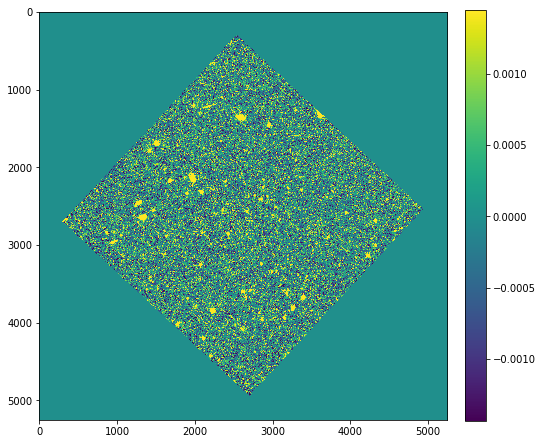

In [3]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))

norm_image = ImageNormalize(data, interval=ZScaleInterval())
fitsplot = ax1.imshow(data, norm=norm_image)
fig.colorbar(fitsplot, fraction=0.046, pad=0.04)

plt.show()

# Add uneven background

In [11]:
mask = data == 0
n_data_pixels = len(data[~mask])

background = np.linspace(-1e-4, 5e-4, num=n_data_pixels)

# new_data = np.zeros_like(data)
new_data = np.copy(data)
i_background = 0
for i_row, row in enumerate(data):
    for i_col, value in enumerate(row):
        if not mask[i_row, i_col]:
            new_data[i_row, i_col] += background[i_background]
            i_background += 1
#         else:
#             new_data[i_row, i_col] = value

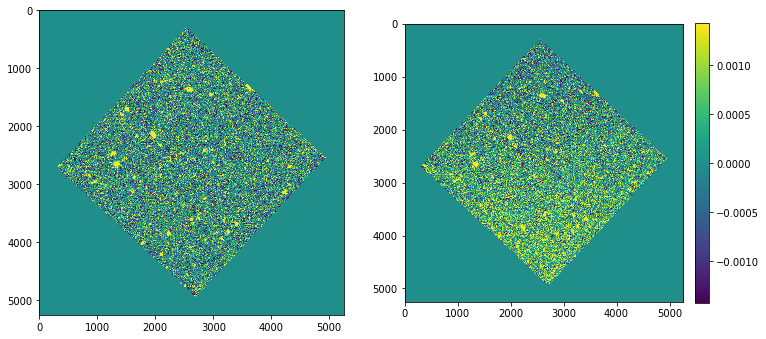

In [12]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 8))

norm_image = ImageNormalize(new_data, interval=ZScaleInterval())

fitsplot1 = ax1.imshow(data, norm=norm_image)

fitsplot2 = ax2.imshow(new_data, norm=norm_image)
fig.colorbar(fitsplot2, fraction=0.046, pad=0.04)

plt.show()

In [14]:
# Save out file
hdu = fits.PrimaryHDU(new_data)
# hdu.writeto('data/hlsp_xdf_hst_acswfc-60mas_hudf_f435w_v1_sci_backgroundadded.fits', overwrite=True)

In [36]:
# Just plot "signal"?
mean, median, std = sigma_clipped_stats(new_data, sigma=3.0, iters=5, mask=mask)
data_signal = new_data * [new_data > mean]

In [39]:
print(data_signal, np.average(data_signal))

[[[ 0. -0.  0. ...,  0.  0. -0.]
  [ 0.  0.  0. ..., -0.  0. -0.]
  [-0. -0. -0. ..., -0. -0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0. -0.]
  [ 0.  0.  0. ...,  0. -0.  0.]
  [ 0.  0.  0. ...,  0. -0.  0.]]] 0.000270584


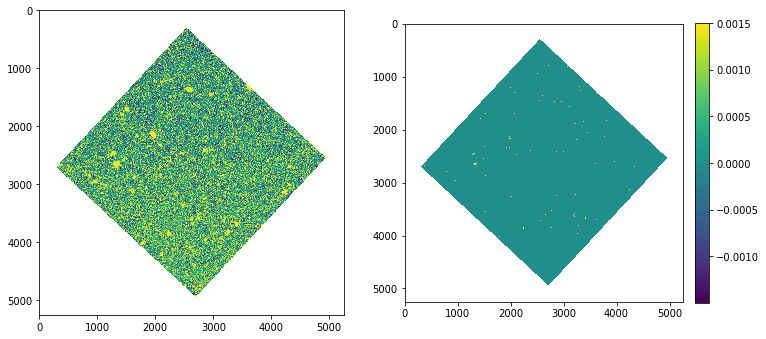

In [31]:
# Just plot "signal"?
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 8))

norm_image = ImageNormalize(new_data, interval=ZScaleInterval())

fitsplot1 = ax1.imshow(np.ma.masked_where(mask, new_data), norm=norm_image)

fitsplot2 = ax2.imshow(np.ma.masked_where(mask, data_signal), norm=norm_image)
fig.colorbar(fitsplot2, fraction=0.046, pad=0.04)

plt.show()

# Try to calculate SNR

In [ ]:
from astropy.stats import sigma_clip

old_noise_data = sigma_clip(nddata.data * ~nddata.mask, sigma=3, iters=5)
old_noise_data.fill_value = 0
old_signal_data = nddata.data - old_noise_data.filled() * ~nddata.mask

signal_old = np.average(old_signal_data * ~nddata.mask)
noise_old = np.std(old_noise_data * ~nddata.mask)
snr_old = signal_old/noise_old

new_noise_data = sigma_clip(data_scalarsubtraction * ~nddata.mask, sigma=3, iters=5)
new_noise_data.fill_value = 0
new_signal_data = data_scalarsubtraction - new_noise_data.filled() * ~nddata.mask

signal_new = np.average(new_signal_data * ~nddata.mask)
noise_new = np.std(new_noise_data * ~nddata.mask)
snr_new = signal_old/noise_new

print(signal_old, noise_old, snr_old)
print(signal_new, noise_new, snr_new)

In [ ]:
from astropy.stats import signal_to_noise_oir_ccd

t = 152e3 * 164
source_eps = np.sum(old_signal_data)
sky_eps = np.sum(old_noise_data)
print(source_eps, sky_eps)
dark_eps = 0 # dark subtraction already happened?
rd = 0
npix = len([p for p in nddata.mask.flatten() if p is False])

signal_to_noise_oir_ccd(t, source_eps, sky_eps, dark_eps, rd, npix, gain=2)

# Trying to query from MAST

In [2]:
# Figure out what you want to download from MAST
obsTable = Observations.query_object("UDF",radius=".02 deg")
dataProductsByObservation = Observations.get_product_list(obsTable[0:2])
print(dataProductsByObservation)

   obsID    obs_collection dataproduct_type ...   size   parent_obsid
----------- -------------- ---------------- ... -------- ------------
15000776383          SWIFT             cube ...    12164  15000776383
15000776383          SWIFT             cube ... 14529600  15000776383
15000776383          SWIFT             cube ...     3538  15000776383
15000776384          SWIFT             cube ...    12164  15000776384
15000776384          SWIFT             cube ... 14391400  15000776384
15000776384          SWIFT             cube ...     3538  15000776384


In [4]:
with fits.open('data/h_sv_sect12_v2.0_drz_img.fits') as hdulist:
    v_data = hdulist[0].data
with fits.open('data/h_sb_sect12_v2.0_drz_img.fits') as hdulist:
    b_data = hdulist[0].data

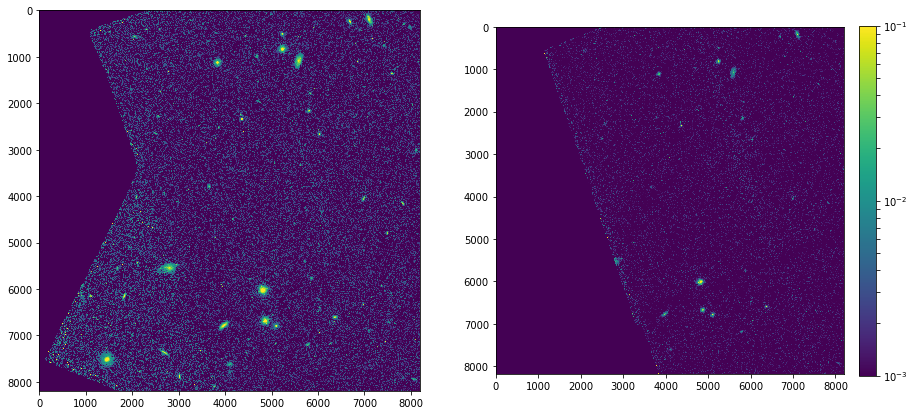

In [5]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 8))

clim = (1e-3, 1e-1)

v_data[v_data <= 0] = 1e-6
b_data[b_data <= 0] = 1e-6

ax1.imshow(v_data, norm=LogNorm(), clim=clim)
fitsplot = ax2.imshow(b_data, norm=LogNorm(), clim=clim)
fig.colorbar(fitsplot, fraction=0.046, pad=0.04)

plt.show()